In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset, TensorDataset
import h5py
import matplotlib.pyplot as plt
import random
import os
import time
import gc
from torch.amp import autocast, GradScaler

# --- configuration ---
PHOTON_FILE = 'photons.hdf5'
ELECTRON_FILE = 'electrons.hdf5'
MODEL_SAVE_PATH = 'electron_photon_resnet15.pth'
OPTIMIZER_SAVE_PATH = MODEL_SAVE_PATH + ".opt"

# --- hyperparameters ---
SEED = 42
BATCH_SIZE = 512
LEARNING_RATE = 5e-6
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 30
NUM_WORKERS = 0 # 0 for no multiprocessing, >0 for using multiple workers, helps with batch collation, turn off if causing issues (esp. on Windows)
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2

# --- feature flags ---
USE_LOG_TRANSFORM = True # apply log(1+E) during preprocessing
USE_AUGMENTATION = True # apply light augmentations during training
USE_MIXED_PRECISION = torch.cuda.is_available()

# --- reproducibility ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Mixed Precision Training Enabled: {USE_MIXED_PRECISION}")

# --- file checks ---
if not os.path.exists(PHOTON_FILE): raise FileNotFoundError(f"Photon file not found: {PHOTON_FILE}")
if not os.path.exists(ELECTRON_FILE): raise FileNotFoundError(f"Electron file not found: {ELECTRON_FILE}")

Using device: cuda
Mixed Precision Training Enabled: True


In [2]:
def load_data_to_device(photon_file, electron_file, device):
    print("Loading data from HDF5 files into RAM...")
    start_time = time.time()
    with h5py.File(photon_file, 'r') as f:
        photon_X_np = f['X'][:] # shape (N, H, W, C)
        photon_y_np = f['y'][:] # shape (N,)
        num_photons = len(photon_y_np)
    with h5py.File(electron_file, 'r') as f:
        electron_X_np = f['X'][:]
        electron_y_np = f['y'][:]
        num_electrons = len(electron_y_np)

    print(f"Loaded {num_photons} photons and {num_electrons} electrons.")

    # concatenate the ndarrays
    X_np = np.concatenate([photon_X_np, electron_X_np], axis=0).astype(np.float32)
    y_np = np.concatenate([photon_y_np, electron_y_np], axis=0).astype(np.float32)

    # add channel dimension for labels (N, 1)
    y_np = np.expand_dims(y_np, axis=-1)

    ram_load_time = time.time() - start_time
    print(f"Data loaded into RAM in {ram_load_time:.2f}s.")
    print(f"Combined X shape: {X_np.shape}, dtype: {X_np.dtype}")
    print(f"Combined y shape: {y_np.shape}, dtype: {y_np.dtype}")

    print(f"Moving data to device {device}...")
    start_time = time.time()
    # convert to torch tensors and move to device
    # keep X in (N, H, W, C) format for now, preprocessing will handle permutations
    X_tensor = torch.from_numpy(X_np).to(device)
    y_tensor = torch.from_numpy(y_np).to(device)
    gpu_load_time = time.time() - start_time
    print(f"Data moved to {device} in {gpu_load_time:.2f}s.")

    # log GPU memory usage
    if device.type == 'cuda':
        print(f"GPU Memory Used (X): {X_tensor.element_size() * X_tensor.nelement() / (1024**3):.2f} GB")
        print(f"GPU Memory Used (y): {y_tensor.element_size() * y_tensor.nelement() / (1024**3):.2f} GB")
        print(f"Total GPU Memory Used: {(X_tensor.element_size() * X_tensor.nelement() + y_tensor.element_size() * y_tensor.nelement()) / (1024**3):.2f} GB")

    return X_tensor, y_tensor, num_photons, num_electrons

# move data onto device
X_device, y_device, num_photons, num_electrons = load_data_to_device(PHOTON_FILE, ELECTRON_FILE, device)
total_samples = num_photons + num_electrons

# define labels (obtained by introspection)
PHOTON_LABEL = 0.0
ELECTRON_LABEL = 1.0

Loading data from HDF5 files into RAM...
Loaded 249000 photons and 249000 electrons.
Data loaded into RAM in 26.86s.
Combined X shape: (498000, 32, 32, 2), dtype: float32
Combined y shape: (498000, 1), dtype: float32
Moving data to device cuda...
Data moved to cuda in 1.12s.
GPU Memory Used (X): 3.80 GB
GPU Memory Used (y): 0.00 GB
Total GPU Memory Used: 3.80 GB


In [3]:
@torch.no_grad()
def apply_log_transform(x_tensor_nhwc): # input is NHWC
    print("Applying log1p transform to energy channel...")
    x_working = x_tensor_nhwc.clone()
    x_working[..., 0] = torch.log1p(torch.relu(x_working[..., 0]))

    return x_working

if USE_LOG_TRANSFORM:
    X_device = apply_log_transform(X_device)
    torch.cuda.empty_cache()
    gc.collect()

Applying log1p transform to energy channel...



Plotting prenorm histograms using 400000 random samples...
- x_prenorm_nchw.shape: torch.Size([498000, 2, 32, 32])
- y_tensor.shape: torch.Size([498000, 1])
Prenorm histogram data prepared in 6.11s.


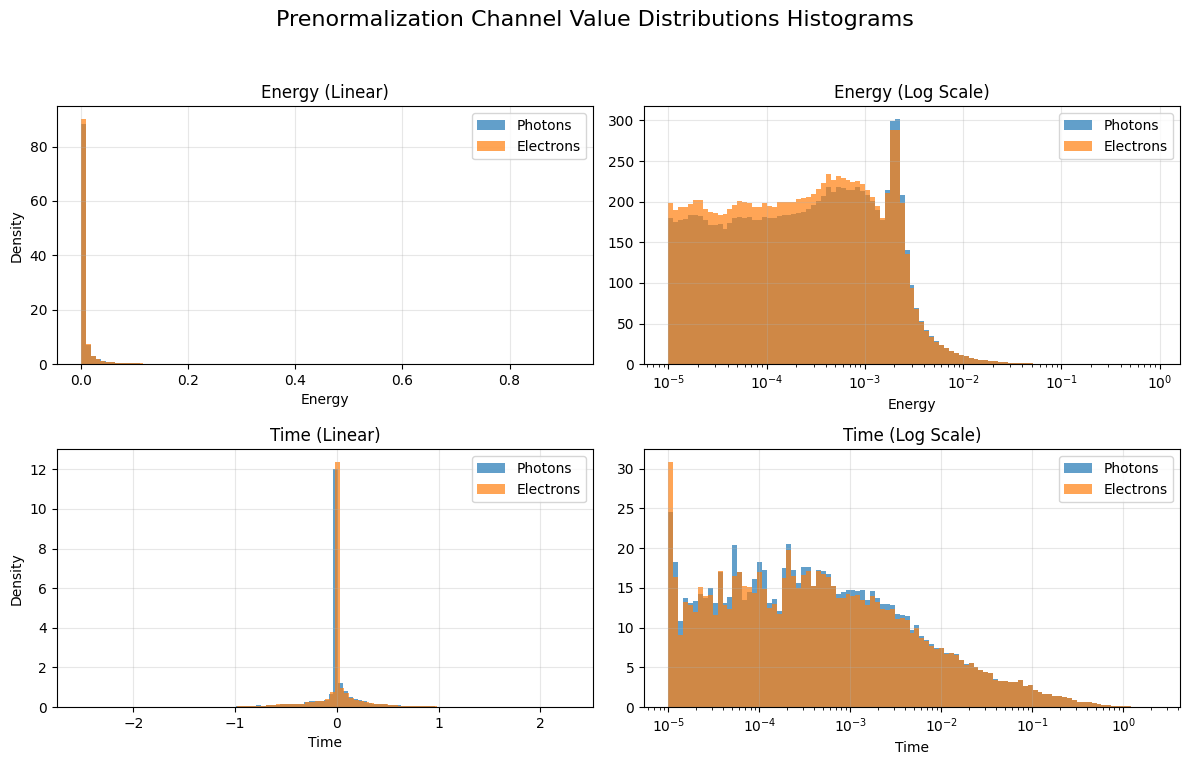

In [4]:
def plot_prenorm_histograms(x_prenorm_nhwc, y_tensor, num_samples_hist=400000):
    """Plots histograms of data before normalization."""
    print(f"\nPlotting prenorm histograms using {num_samples_hist} random samples...")

    x_prenorm_nchw = x_prenorm_nhwc.permute(0, 3, 1, 2).contiguous()
    
    print(f"- x_prenorm_nchw.shape: {x_prenorm_nchw.shape}")
    print(f"- y_tensor.shape: {y_tensor.shape}")
    start_time = time.time()

    plot_indices = np.random.choice(x_prenorm_nchw.shape[0], num_samples_hist, replace=False)

    # sample data
    sampled_x = x_prenorm_nchw[plot_indices]
    sampled_y = y_tensor[plot_indices]

    # separate photons and electrons
    photon_mask = (sampled_y == PHOTON_LABEL).squeeze()
    electron_mask = (sampled_y == ELECTRON_LABEL).squeeze()

    # extract data
    photon_energies = sampled_x[photon_mask, 0, :, :].flatten().cpu().numpy()
    photon_times = sampled_x[photon_mask, 1, :, :].flatten().cpu().numpy()
    electron_energies = sampled_x[electron_mask, 0, :, :].flatten().cpu().numpy()
    electron_times = sampled_x[electron_mask, 1, :, :].flatten().cpu().numpy()

    del sampled_x, sampled_y, x_prenorm_nchw
    torch.cuda.empty_cache()
    gc.collect()

    def filter_data(arr):
        # keep finite values, filter near-zero
        return arr[np.isfinite(arr) & (np.abs(arr) > 1e-6)]
    
    photon_energies = filter_data(photon_energies)
    electron_energies = filter_data(electron_energies)
    photon_times = filter_data(photon_times)
    electron_times = filter_data(electron_times)

    print(f"Prenorm histogram data prepared in {time.time() - start_time:.2f}s.")

    # --- plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Prenormalization Channel Value Distributions Histograms", fontsize=16)

    # column titles
    axes[0, 0].set_title('Energy (Linear)')
    axes[0, 1].set_title('Energy (Log Scale)')
    axes[1, 0].set_title('Time (Linear)')
    axes[1, 1].set_title('Time (Log Scale)')

    # energy linear
    axes[0, 0].hist(photon_energies, bins=100, alpha=0.7, label='Photons', density=True)
    axes[0, 0].hist(electron_energies, bins=100, alpha=0.7, label='Electrons', density=True)
    axes[0, 0].set_xlabel('Energy')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # energy log
    min_e_pre = min(photon_energies.min(), electron_energies.min()) if len(photon_energies) > 0 and len(electron_energies) > 0 else 1e-5
    max_e_pre = max(photon_energies.max(), electron_energies.max()) if len(photon_energies) > 0 and len(electron_energies) > 0 else 1.0
    log_bins_e_pre = np.logspace(np.log10(max(1e-5, min_e_pre)), np.log10(max_e_pre), 100)
    axes[0, 1].hist(photon_energies, bins=log_bins_e_pre, alpha=0.7, label='Photons', density=True)
    axes[0, 1].hist(electron_energies, bins=log_bins_e_pre, alpha=0.7, label='Electrons', density=True)
    axes[0, 1].set_xlabel('Energy')
    axes[0, 1].set_xscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # time linear
    axes[1, 0].hist(photon_times, bins=100, alpha=0.7, label='Photons', density=True)
    axes[1, 0].hist(electron_times, bins=100, alpha=0.7, label='Electrons', density=True)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # time log
    min_t_pre = min(photon_times.min(), electron_times.min()) if len(photon_times) > 0 and len(electron_times) > 0 else 1e-5
    max_t_pre = max(photon_times.max(), electron_times.max()) if len(photon_times) > 0 and len(electron_times) > 0 else 1.0
    log_bins_t_pre = np.logspace(np.log10(max(1e-5, min_t_pre)), np.log10(max_t_pre), 100)
    axes[1, 1].hist(photon_times, bins=log_bins_t_pre, alpha=0.7, label='Photons', density=True)
    axes[1, 1].hist(electron_times, bins=log_bins_t_pre, alpha=0.7, label='Electrons', density=True)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_xscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_prenorm_histograms(X_device, y_device)

In [5]:
@torch.no_grad()
def compute_stats(x_tensor_nhwc): # input is NHWC
    print("Computing mean and std...")
    # compute mean and std for each channel
    # calculate over N, H, W dimensions of the NHWC tensor, keep C dimension
    mean = torch.mean(x_tensor_nhwc, dim=(0, 1, 2), keepdim=False)
    std = torch.std(x_tensor_nhwc, dim=(0, 1, 2), keepdim=False)
    std = torch.clamp(std, min=1e-6)

    print(f"Calculated Mean: {mean.cpu().numpy()}")
    print(f"Calculated Std Dev: {std.cpu().numpy()}")

    return mean, std

@torch.no_grad()
def normalize(x_tensor_nhwc, mean, std):
    print("Applying normalization...")
    # reshape mean/std for broadcasting: (1, 1, 1, C) to match NHWC tensor
    mean_reshaped = mean.view(1, 1, 1, -1)
    std_reshaped = std.view(1, 1, 1, -1)

    return (x_tensor_nhwc - mean_reshaped) / std_reshaped

mean, std = compute_stats(X_device)
X_device = normalize(X_device, mean, std)
X_device = X_device.permute(0, 3, 1, 2).contiguous() # permute to NCHW format for PyTorch

torch.cuda.empty_cache()
gc.collect()

Computing mean and std...
Calculated Mean: [ 0.00102406 -0.00026181]
Calculated Std Dev: [0.01807128 0.06738362]
Applying normalization...


849

Plotting sample images...


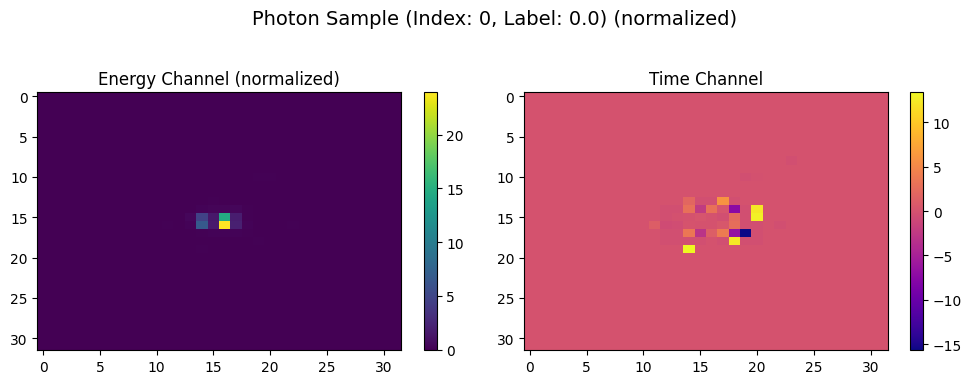

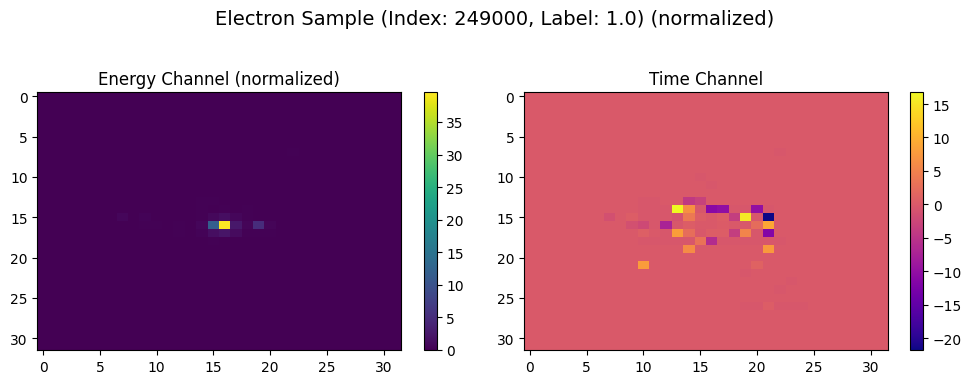


Plotting histograms of normalized data using 400000 random samples...
Histogram data prepared in 5.52s.


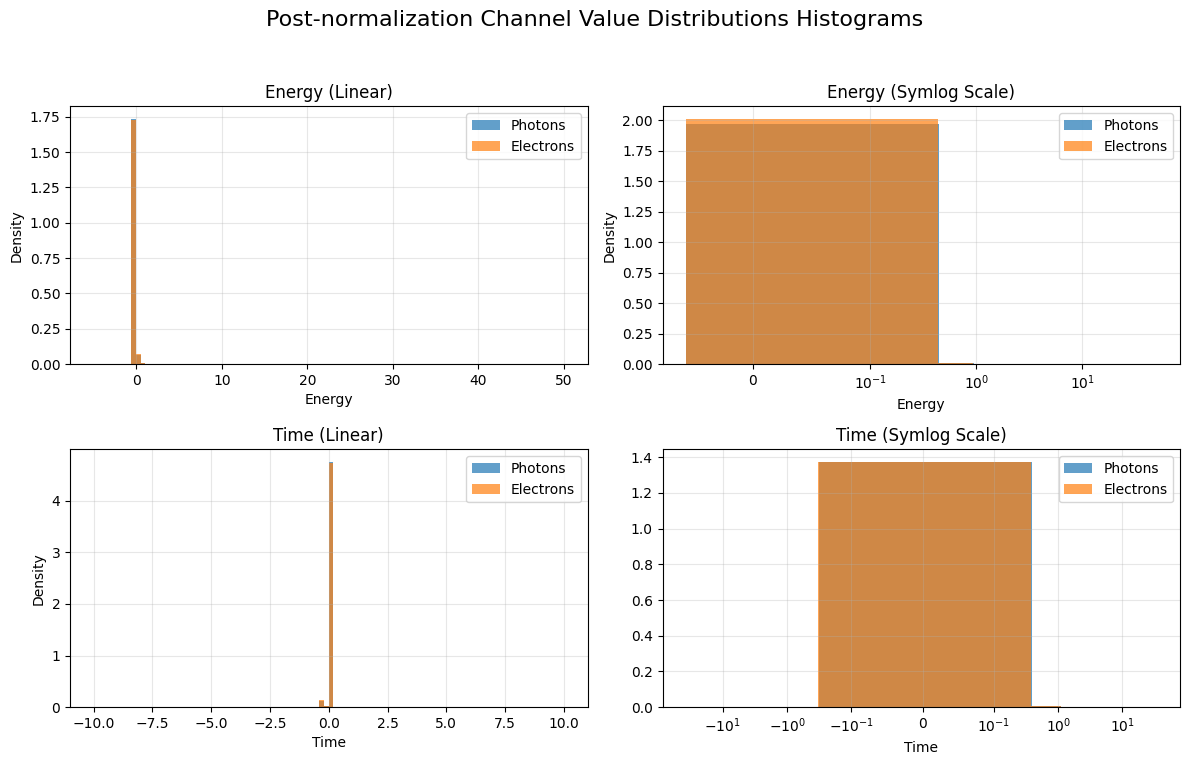

In [6]:
def plot_sample(x_tensor_nchw, y_tensor, index, particle_type_str):
    """Plots (normalized) Energy and Time channels for a single sample from the dataset."""
    # input x_tensor_nchw shape: (N, C, H, W)
    img_chw = x_tensor_nchw[index].cpu().numpy() # move to CPU for plotting
    label_val = y_tensor[index].item()

    energy, time = img_chw[0, :, :], img_chw[1, :, :] # recall: C=0 is Energy, C=1 is Time

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"{particle_type_str} Sample (Index: {index}, Label: {label_val}) (normalized)", fontsize=14)

    im_energy = axes[0].imshow(energy, cmap='viridis', aspect='auto')
    axes[0].set_title('Energy Channel (normalized)')
    fig.colorbar(im_energy, ax=axes[0])

    im_time = axes[1].imshow(time, cmap='plasma', aspect='auto')
    axes[1].set_title(f'Time Channel')
    fig.colorbar(im_time, ax=axes[1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_histograms(x_nchw, y, num_samples_hist=400000):
    """Plots histograms of data after normalization."""
    print(f"\nPlotting histograms of normalized data using {num_samples_hist} random samples...")
    start_time = time.time()

    plot_indices = np.random.choice(x_nchw.shape[0], num_samples_hist, replace=False)

    sampled_x = x_nchw[plot_indices]
    sampled_y = y[plot_indices]

    # separate photons and electrons
    photon_mask = (sampled_y == PHOTON_LABEL).squeeze()
    electron_mask = (sampled_y == ELECTRON_LABEL).squeeze()

    photon_energies = sampled_x[photon_mask, 0, :, :].flatten().cpu().numpy()
    photon_times = sampled_x[photon_mask, 1, :, :].flatten().cpu().numpy()
    electron_energies = sampled_x[electron_mask, 0, :, :].flatten().cpu().numpy()
    electron_times = sampled_x[electron_mask, 1, :, :].flatten().cpu().numpy()

    del sampled_x, sampled_y
    torch.cuda.empty_cache()
    gc.collect()

    def filter_data(arr):
        # keep finite values, allow zeros for post-norm data
        return arr[np.isfinite(arr)]

    photon_energies = filter_data(photon_energies)
    electron_energies = filter_data(electron_energies)
    photon_times = filter_data(photon_times)
    electron_times = filter_data(electron_times)

    print(f"Histogram data prepared in {time.time() - start_time:.2f}s.")

    # --- plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Post-normalization Channel Value Distributions Histograms", fontsize=16)

    # column titles
    axes[0, 0].set_title('Energy (Linear)')
    axes[0, 1].set_title('Energy (Symlog Scale)')
    axes[1, 0].set_title('Time (Linear)')
    axes[1, 1].set_title('Time (Symlog Scale)')

    # energy linear
    axes[0, 0].hist(photon_energies, bins=100, range=(-5, 50), alpha=0.7, label='Photons', density=True)
    axes[0, 0].hist(electron_energies, bins=100, range=(-5, 50), alpha=0.7, label='Electrons', density=True)
    axes[0, 0].set_xlabel('Energy')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # energy symlog (better for data centered around zero)
    axes[0, 1].hist(photon_energies, bins=100, alpha=0.7, label='Photons', density=True)
    axes[0, 1].hist(electron_energies, bins=100, alpha=0.7, label='Electrons', density=True)
    axes[0, 1].set_xlabel('Energy')
    axes[0, 1].set_xscale('symlog', linthresh=0.1) # use symlog to see values near zero better
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # time linear
    axes[1, 0].hist(photon_times, bins=100, range=(-10, 10), alpha=0.7, label='Photons', density=True)
    axes[1, 0].hist(electron_times, bins=100, range=(-10, 10), alpha=0.7, label='Electrons', density=True)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # time symlog
    axes[1, 1].hist(photon_times, bins=100, alpha=0.7, label='Photons', density=True)
    axes[1, 1].hist(electron_times, bins=100, alpha=0.7, label='Electrons', density=True)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_xscale('symlog', linthresh=0.1)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("Plotting sample images...")
# use global indices
plot_sample(X_device, y_device, 0, "Photon")
plot_sample(X_device, y_device, num_photons, "Electron")

plot_histograms(X_device, y_device)

In [7]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, block=BasicBlock, layers=[3, 2, 2], num_classes=1, in_channels=2, dropout_prob=0.3):
        super(ResNet15, self).__init__()
        self.in_planes = 64
        # input: (B, C, H, W) = (B, 2, 32, 32)
        self.conv1 = nn.Conv2d(in_channels, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False) # output: (B, 64, 32, 32)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        # no maxpool

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # output: (B, 64, 32, 32)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # output: (B, 128, 16, 16)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # output: (B, 256, 8, 8)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # output: (B, 256, 1, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(256 * block.expansion, num_classes) # output: (B, 1)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    
    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        
        for _ in range(1, num_blocks): 
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # expects input x: (B, C, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        # return raw logits
        return x

# instantiate the model
model = ResNet15().to(device)
print(f"Model Architecture:\n{model}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Model Architecture:
ResNet15(
  (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
# --- data splitting (indices for pre-loaded tensors)
indices = np.arange(total_samples)
np.random.shuffle(indices)

test_split_idx = int(np.floor(TEST_SPLIT * total_samples))
val_split_idx = int(np.floor((VAL_SPLIT + TEST_SPLIT) * total_samples))
test_indices = indices[:test_split_idx]
val_indices = indices[test_split_idx:val_split_idx]
train_indices = indices[val_split_idx:]
print(f"\nDataset Split Indices:")
print(f"  Training: {len(train_indices)} indices")
print(f"  Validation: {len(val_indices)} indices")
print(f"  Test: {len(test_indices)} indices")

# --- create TensorDatasets ---
train_dataset = TensorDataset(X_device[train_indices], y_device[train_indices])
val_dataset = TensorDataset(X_device[val_indices], y_device[val_indices])
test_dataset = TensorDataset(X_device[test_indices], y_device[test_indices])

# --- create DataLoaders ---
persist_workers = NUM_WORKERS > 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=persist_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=persist_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
persistent_workers=persist_workers)

print(f"\nDataLoaders created: Batch Size={BATCH_SIZE}, Num Workers={NUM_WORKERS}, Persistent={persist_workers}")

# --- Loss, Optimizer, Scheduler, Scaler ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1)
scaler = GradScaler(enabled=USE_MIXED_PRECISION)

# --- load checkpoint(s) if present
start_epoch = 0
if os.path.exists(MODEL_SAVE_PATH):
    print(f"\nLoading model weights from {MODEL_SAVE_PATH}...")
    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print("Model weights loaded.")

        if os.path.exists(OPTIMIZER_SAVE_PATH):
            print(f"Loading optimizer/scheduler state from {OPTIMIZER_SAVE_PATH}...")
            
            checkpoint = torch.load(OPTIMIZER_SAVE_PATH, map_location='cpu')
            optimizer.load_state_dict(checkpoint['optimizer'])
            scheduler.load_state_dict(checkpoint['scheduler'])
            start_epoch = checkpoint.get('epoch', 0) + 1

            print(f"Optimizer/scheduler state loaded. Resuming from epoch {start_epoch}...")
        else:
            print("Optimizer state file not found, initializing optimizer from scratch.")
    except Exception as e:
        print(f"WARNING: Could not load checkpoint: {e}. Training from scratch.")
        start_epoch = 0 
else:
    print("\nNo checkpoint found. Starting training from scratch.")


Dataset Split Indices:
  Training: 348600 indices
  Validation: 49800 indices
  Test: 99600 indices

DataLoaders created: Batch Size=512, Num Workers=0, Persistent=False

Loading model weights from electron_photon_resnet15.pth...
Model weights loaded.
Loading optimizer/scheduler state from electron_photon_resnet15.pth.opt...
Optimizer/scheduler state loaded. Resuming from epoch 9...


In [9]:
# --- augmentations ---
@torch.no_grad()
def augment_batch(batch_x, use_augment):
    """Applies augmentations to a batch"""
    if not use_augment:
        return batch_x

    # add Gaussian noise
    if random.random() < 0.5:
        noise = torch.randn_like(batch_x) * 0.1
        batch_x = batch_x + noise # note: not in-place
    
    # tiny shifts
    if random.random() < 0.2:
        shift_h = random.randint(-1, 1)
        shift_w = random.randint(-1, 1)
        batch_x = torch.roll(batch_x, shifts=(shift_h, shift_w), dims=(2, 3))

    return batch_x

def train_one_epoch(model, loader, criterion, optimizer, scaler, device, use_amp, use_augment):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    loop_start_time = time.time()

    for i, (batch_x, batch_y) in enumerate(loader):
        batch_start_time = time.time()

        batch_x = augment_batch(batch_x, use_augment)

        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, enabled=use_amp):
            outputs = model(batch_x) # logits
            loss = criterion(outputs, batch_y)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct = (predicted == batch_y).float().sum().item()
        
        total_correct += correct
        batch_size = batch_y.size(0)
        total_samples += batch_size
        total_loss += loss.item() * batch_size
        
        batch_end_time = time.time()
        
        if i % 100 == 0:
            print(f"  Batch {i:>4}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {correct/batch_size:.4f}, Batch Time: {(batch_end_time - batch_start_time)*1000:.1f}ms")
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    print(f"  Epoch Training Time: {time.time() - loop_start_time:.2f}s")
    
    return avg_loss, avg_acc

def validate_one_epoch(model, loader, criterion, device, use_amp):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    val_start_time = time.time()

    with torch.no_grad():
        for batch_x, batch_y in loader:
            # no augmentation during validation
            with autocast(device_type=device.type, enabled=use_amp):
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct = (predicted == batch_y).float().sum().item()

            total_correct += correct
            total_samples += batch_y.size(0)
            total_loss += loss.item() * batch_y.size(0)
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    print(f"  Validation Time: {time.time() - val_start_time:.2f}s")
    
    return avg_loss, avg_acc

# --- training loop ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
if start_epoch > 0 and 'best' in scheduler.state_dict():
    best_val_loss = scheduler.state_dict()['best'] if scheduler.state_dict()['best'] is not None else float('inf')
    print(f"Resuming with best_val_loss = {best_val_loss:.4f}")

print("\n--- Starting Training ---")
epochs_to_run = NUM_EPOCHS - start_epoch
if epochs_to_run <= 0:
    print("Training already completed.")
else:
    print(f"Running for {epochs_to_run} epochs (from epoch {start_epoch} to {NUM_EPOCHS-1})")

for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, USE_MIXED_PRECISION, USE_AUGMENTATION)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # validation
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, USE_MIXED_PRECISION)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_duration = time.time() - epoch_start_time
    print("-" * 60)
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Duration: {epoch_duration:.2f}s")
    print("-" * 60)

    # scheduler step
    scheduler.step(val_loss)
    print(f"LR (after scheduler step): {scheduler.get_last_lr()}")

    if val_loss < best_val_loss: # save best model
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        checkpoint = {'optimizer': optimizer.state_dict(), 
                      'scheduler': scheduler.state_dict(),
                      'epoch': epoch}
        torch.save(checkpoint, OPTIMIZER_SAVE_PATH)

print("\n--- Training Finished ---")

Resuming with best_val_loss = 0.5469

--- Starting Training ---
Running for 21 epochs (from epoch 9 to 29)

Epoch 10/30, Current LR: 0.000500
  Batch    0/680, Loss: 0.5811, Acc: 0.7129, Batch Time: 1371.9ms
  Batch  100/680, Loss: 0.5385, Acc: 0.7305, Batch Time: 148.9ms
  Batch  200/680, Loss: 0.5116, Acc: 0.7598, Batch Time: 147.0ms
  Batch  300/680, Loss: 0.5472, Acc: 0.7305, Batch Time: 150.1ms
  Batch  400/680, Loss: 0.5313, Acc: 0.7480, Batch Time: 148.5ms
  Batch  500/680, Loss: 0.5675, Acc: 0.7188, Batch Time: 149.5ms
  Batch  600/680, Loss: 0.5297, Acc: 0.7578, Batch Time: 148.8ms
  Epoch Training Time: 105.60s
  Validation Time: 5.08s
------------------------------------------------------------
Epoch 10 Summary:
  Train Loss: 0.5455, Train Acc: 0.7298
  Val Loss: 0.5500, Val Acc: 0.7266
  Duration: 110.69s
------------------------------------------------------------
LR (after scheduler step): [0.0005]

Epoch 11/30, Current LR: 0.000500
  Batch    0/680, Loss: 0.5349, Acc: 0.

KeyboardInterrupt: 